In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Build the dataset for exploratory data analysis and visualization

In [2]:
df = pd.read_csv('ks-projects-201801.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## Construct a new variable "number of words in the KS project name"

In [4]:
df['name'].head()

0                      The Songs of Adelaide & Abullah
1        Greeting From Earth: ZGAC Arts Capsule For ET
2                                       Where is Hank?
3    ToshiCapital Rekordz Needs Help to Complete Album
4    Community Film Project: The Art of Neighborhoo...
Name: name, dtype: object

In [5]:
df['name'] = df['name'].apply(lambda x: str(x))

In [6]:
df['len_name'] = df['name'].apply(lambda x: len(x.split()))

## Construct "deadline year", "deadline month", "launched year", "launched month" and "time of duration" variables

In [7]:
df['deadline_year'] = pd.DatetimeIndex(df['deadline']).year
df['deadline_month'] = pd.DatetimeIndex(df['deadline']).month
df['launched_year'] = pd.DatetimeIndex(df['launched']).year
df['launched_month'] = pd.DatetimeIndex(df['launched']).month

In [8]:
df['deadline']=pd.to_datetime(df['deadline'])

In [9]:
df['launched']=pd.to_datetime(df['launched'])

In [10]:
df['time_of_duration'] = (df['deadline'] - df['launched']).apply(lambda x: x.days)

## Construct a new variable "usd pledged per backer"

In [11]:
def pledged_per_backer(x):
    if x['backers'] == 0:
        return 0
    else:
        return x['usd_pledged_real']/x['backers']

df['usd_pledged_per_backer'] = df.apply(lambda x: pledged_per_backer(x), axis = 1)

In [12]:
df['usd_pledged_per_backer'].unique()

array([  0.        , 161.4       ,  73.33333333, ...,  55.8716129 ,
        63.89346154,  79.88416667])

## Construct a new variable "the percentage of the goal achieved" meaning the extent of goal fulfillment

In [13]:
df['percentage_goal_achieved'] = df['usd_pledged_real'] / df['usd_goal_real']

In [14]:
df['percentage_goal_achieved'].unique()

array([0.        , 0.0807    , 0.00488889, ..., 1.10019846, 1.07500028,
       0.02369231])

In [15]:
(df['usd pledged'] == df['usd_pledged_real']).mean()

0.6935781609407887

## Construct a new dataset "rate of success" of which the columns are launched_year, main category, and success rate

In [16]:
df['launched_year'].unique()

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018])

In [17]:
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [18]:
years=sorted([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 2018])
category = ['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism']
rate_of_suc=[]
years_final=[]
cat_final=[]
for year in years:
    for cat in category:
        rate_of_suc.append((df[(df['launched_year'] == year)&(df['main_category']==cat)]['state'] == 'successful').mean())
        years_final.append(year)
    cat_final+=category

In [19]:
df_ros=pd.DataFrame(data={"year": years_final, "category":cat_final,"rate_of_success":rate_of_suc})
df_ros.to_csv("rate_of_success.csv")

## Examine the duplicates and missing values

In [20]:
df = df.drop_duplicates()
len(df) #no duplicated rows

378661

In [21]:
df.isnull().any() #usd pledged and usd_pledged_real is confusing. Only use usd_pledged_real here.

ID                          False
name                        False
category                    False
main_category               False
currency                    False
deadline                    False
goal                        False
launched                    False
pledged                     False
state                       False
backers                     False
country                     False
usd pledged                  True
usd_pledged_real            False
usd_goal_real               False
len_name                    False
deadline_year               False
deadline_month              False
launched_year               False
launched_month              False
time_of_duration            False
usd_pledged_per_backer      False
percentage_goal_achieved    False
dtype: bool

## Save as a new dataset

In [22]:
df.to_csv('data.csv')

# Logistics regression 

In [23]:
df_for_logistics = df[['len_name', 'category', 'main_category', 'currency', 
                       'state', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real',
                       'deadline_year', 'deadline_month', 'launched_year', 'launched_month', 
                       'usd_pledged_per_backer', 'time_of_duration', 'percentage_goal_achieved']].copy()

In [24]:
df_for_logistics.head()

,len_name,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month,usd_pledged_per_backer,time_of_duration,percentage_goal_achieved
0,6,Poetry,Publishing,GBP,failed,0,GB,0.0,1533.95,2015,10,2015,8,0.000000,58,0.000000
1,8,Narrative Film,Film & Video,USD,failed,15,US,2421.0,30000.00,2017,11,2017,9,161.400000,59,0.080700
2,3,Narrative Film,Film & Video,USD,failed,3,US,220.0,45000.00,2013,2,2013,1,73.333333,44,0.004889
3,7,Music,Music,USD,failed,1,US,1.0,5000.00,2012,4,2012,3,1.000000,29,0.000200
4,8,Film & Video,Film & Video,USD,canceled,14,US,1283.0,19500.00,2015,8,2015,7,91.642857,55,0.065795


In [25]:
df_for_logistics['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.feature_selection import RFE

In [27]:
df_for_logistics['state']=[1  if s == 'successful' else 0 for s in df_for_logistics['state']]

In [28]:
y=df_for_logistics['state']
X=df_for_logistics.drop(['state'],axis=1)
cols=X.columns
encoder=sklearn.preprocessing.LabelEncoder()
#encoding
X['category']=encoder.fit_transform(X['category'])
X['main_category']=encoder.fit_transform(X['main_category'])
X['currency']=encoder.fit_transform(X['currency'])
X['country']=encoder.fit_transform(X['country'])


In [29]:
logistics_data = pd.concat([X,y],axis=1)
logistics_data.head()
logistics_data.to_csv('logistics_data.csv')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
pred=logreg.predict(X_test)
accuracy=(pred==y_test).mean()
print(accuracy)

0.9814875130943054


In [32]:
rfe = RFE(logreg,n_features_to_select=1)
rfe = rfe.fit(X, y)
feature_ranking=list(rfe.ranking_)
for f in feature_ranking:
    print(f,X_train.columns[f-1])

10 deadline_month
9 deadline_year
12 launched_month
1 len_name
4 currency
5 backers
8 usd_goal_real
7 usd_pledged_real
11 launched_year
15 percentage_goal_achieved
13 usd_pledged_per_backer
3 main_category
6 country
2 category
14 time_of_duration


# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf=RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [34]:
clf.score(X_test,y_test)

0.995897851213479

In [35]:
importance=list(clf.feature_importances_)
sorted(zip(importance,X_train.columns),key=lambda x: x[0],reverse=True)

[(0.5298827665849134, 'percentage_goal_achieved'),
 (0.18700931314488262, 'usd_pledged_real'),
 (0.17836049512179408, 'backers'),
 (0.055834940733065316, 'usd_pledged_per_backer'),
 (0.03478117695333135, 'usd_goal_real'),
 (0.004943644422484364, 'time_of_duration'),
 (0.003896148196552558, 'deadline_year'),
 (0.0024490524163158947, 'launched_year'),
 (0.0010448401955619102, 'len_name'),
 (0.0006231043005139455, 'main_category'),
 (0.000531815362116268, 'country'),
 (0.00047409908739765526, 'category'),
 (0.000143632530041486, 'currency'),
 (1.4851492187010954e-05, 'deadline_month'),
 (1.01194588423093e-05, 'launched_month')]

## Construct new datasets including only the name of the successful and failed projects

In [37]:
df_for_text_successful = df[df['state'] == 'successful']['name']
df_for_text_failed = df[df['state'] == 'failed']['name']

In [38]:
df_for_text_successful.to_csv('text_successful.csv')

In [39]:
df_for_text_failed.to_csv('text_failed.csv')

## Plot word cloud

In [40]:
!pip install wordcloud

You are using pip version 9.0.2, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

In [43]:
df_for_text_successful.columns = ['id', 'name']
df_for_text_successful=df_for_text_successful.reset_index(drop=False)

In [44]:
text = " ".join(name for name in df_for_text_successful.name)
print ("There are {} Kickstarter projects succeeded since 2009.".format(len(text)))

There are 4989075 Kickstarter projects succeeded since 2009.


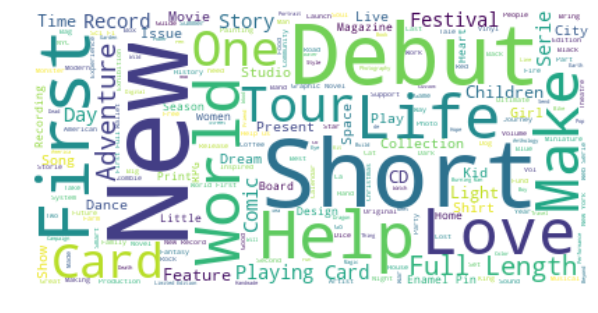

In [45]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Film", "Book", "Album", "Project", "Art", "Game", "Music", "EP", "Documentary", "Video"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
df_for_text_failed.columns = ['id', 'name']
df_for_text_failed=df_for_text_failed.reset_index(drop=False)

In [47]:
text = " ".join(name for name in df_for_text_failed.name)
print ("There are {} Kickstarter projects failed since 2009.".format(len(text)))

There are 6692534 Kickstarter projects failed since 2009.


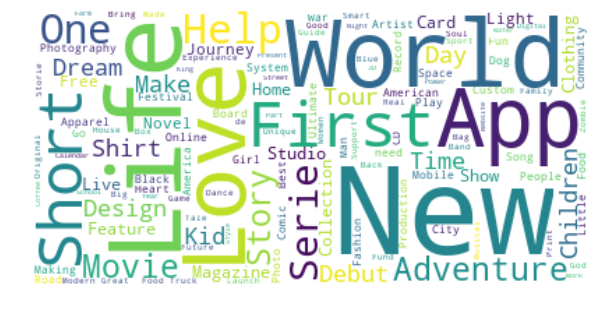

In [48]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Film", "Book", "Album", "Project", "Art", "Game", "Music", "EP", "Documentary", "Video"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()